# Mount Drive and Accelerator status

In [1]:
! nvidia-smi

Thu Dec  9 09:14:49 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import torch
import os
try:
    tpu = False
    assert torch.cuda.is_available()
    gpu = True
    ! nvidia-smi
except:
    tpu = True
    gpu = False
    if 'COLAB_TPU_ADDR' not in os.environ:
        print('ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!')
    else:
        tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
        print ('TPU address is', tpu_address)
    import tensorflow as tf
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu=tpu_address)
    tf.config.experimental_connect_to_cluster(resolver)
    # This is the TPU initialization code that has to be at the beginning.
    tf.tpu.experimental.initialize_tpu_system(resolver)
    print("All devices: ", tf.config.list_logical_devices('TPU'))
    strategy = tf.distribute.TPUStrategy(resolver)

Thu Dec  9 09:15:13 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    30W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
! pip install keras_tuner

     |████████████████████████████████| 98 kB 3.9 MB/s 


# Import Libraries

In [5]:
import tensorflow
from tensorflow import keras
import keras_tuner as kt
import os
import numpy as np
# import keras
import keras.backend as K
from tensorflow.keras.layers import Input, Masking, LSTM, Dropout, Permute, Conv1D, BatchNormalization, Activation, GlobalAveragePooling1D, concatenate, multiply, Reshape, Dense, GRU, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras import Input
from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.constraints import max_norm as maxnorm
import seaborn as sns
import tensorflow.keras.metrics as metrics
import tensorflow.keras as keras
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# Utility Functions for loading dataset, plots and performance

In [6]:
def load_X(path):
    X_signals = []
    files = os.listdir(path)
    files.sort(key=str.lower)
    #['train_acc_x.txt', 'train_acc_y.txt', 'train_acc_z.txt', 'train_gyr_x.txt', 'train_gyr_y.txt', 'train_gyr_z.txt']
    for my_file in files:
        fileName = os.path.join(path,my_file)
        file = open(fileName, 'r')
        X_signals.append(
            [np.array(cell, dtype=np.float32) for cell in [
                row.strip().split(' ') for row in file
            ]]
        )
        file.close()
        #X_signals = 6*totalStepNum*128
    X_signals = np.transpose(np.array(X_signals), (1, 0, 2))#(totalStepNum*6*128)
    return X_signals.reshape(-1,6,128,1)#(totalStepNum*6*128*1)

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]],
        dtype=np.int32
    )
    file.close()
    # Substract 1 to each output class for friendly 0-based indexing
    y_ = y_ - 1
    #one_hot
    y_ = y_.reshape(len(y_))
    n_values = int(np.max(y_)) + 1
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]  # Returns FLOATS

In [7]:
def get_test_performance(model, X_test, test_label):
    score=model.evaluate(X_test,test_label,verbose=1)
    print(f'Test loss:{score[0]}')
    print(f'Test accuracy:{score[1]}')
    print(f'Test Recall: {score[3]}')
    print(f'Test AUC: {score[2]}')

In [8]:
def plot_performance(X_train, train_label, history):
    plt.plot(history.history['accuracy'])
    try:
        plt.plot(history.history['val_accuracy'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
    except:
        pass
    try:
        plt.legend(['val'], loc='upper left')
    except:
        pass
    plt.show()

    plt.plot(history.history['loss'])
    try:
        plt.plot(history.history['val_loss'])
    except:
        pass
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    try:
        plt.legend(['val'], loc='upper left')
    except:
        pass
    plt.show()

In [9]:
def squeeze_excite_block(tensor, ratio=16):
    init = tensor
    # channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    filters = init.shape[-1]
    se_shape = (1, filters)

    se = GlobalAveragePooling1D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    # if K.image_data_format() == 'channels_first':
    #     se = Permute((3, 1, 2))(se)

    x = multiply([init, se])
    return x

# Tuner

In [10]:
np.random.seed(42)
num_classes = 118
X_train = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/train/Inertial Signals')
X_test = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/test/Inertial Signals')
train_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/train/y_train.txt')
test_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/test/y_test.txt')
shape = ((X_train.shape[1], X_train.shape[2]), train_label.shape[1])

In [11]:
def post_se(hp):
    ip = Input(shape=(6, 128))
    x = Masking()(ip)
    x = Bidirectional(LSTM(units=hp.Choice('Bi-LSTM_1', values = [8,16,32,64,128,256,512])))(x)
    # x = Bidirectional(LSTM(units=hp.Choice('Bi-LSTM_2', values = [8,16,32,64,128,256,512])))(x)
    x = Dropout(hp.Choice(name='Dropout', values = [0.0,0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]))(x)
    y = Permute((2, 1))(ip)
    y = Conv1D(hp.Choice('conv_1_filter', values = [32,64,128,256,512]), hp.Choice(name='conv_1_filter_size', values = [3,5,7,8,9]), padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = squeeze_excite_block(y)
    y = Conv1D(hp.Choice('conv_2_filter', values = [32,64,128,256,512]), hp.Choice(name='conv_2_filter_size',values = [3,5,7,8,9]), padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = squeeze_excite_block(y)
    y = Conv1D(hp.Choice('conv_3_filter', values = [32,64,128,256,512,]), hp.Choice(name='conv_3_filter_size',values = [3,5,7,8,9]), padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = GlobalAveragePooling1D()(y)
    x = concatenate([x,y])
    # batch_size = hp.Choice('batch_size', values=[32, 64, 128, 256, 512, 1024, 2048, 4096])
    out = Dense(num_classes, activation='softmax')(x)
    model = Model(ip, out)
    if gpu:
        opt = keras.optimizers.Adam(learning_rate=0.001)
    if tpu:
        opt = keras.optimizers.Adam(learning_rate=8*0.001)
    model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])
    # model.summary()

    return model

# Tune on 90% data

In [ ]:
if gpu:
    tuner = kt.tuners.BayesianOptimization(post_se,
        objective='val_accuracy',
        max_trials=30,
        seed=42,
        project_name='Model_gpu')
    # Will stop training if the "val_loss" hasn't improved in 30 epochs.
    tuner.search(X_train, train_label, epochs=200, validation_split=0.1, shuffle=True, callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30)])

if tpu:
    print("TPU")
    with strategy.scope():
        tuner = kt.tuners.BayesianOptimization(post_se,
            objective='val_accuracy',
            max_trials=30,
            seed=42,
            project_name='Model_tpu')
        # Will stop training if the "val_loss" hasn't improved in 30 epochs.
        tuner.search(X_train, train_label, epochs=200, validation_split=0.1, shuffle=True, callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30)])

Trial 6 Complete [01h 17m 34s]
val_accuracy: 0.9960737228393555

Best val_accuracy So Far: 0.9969797730445862
Total elapsed time: 05h 23m 11s

Search: Running Trial #7

Hyperparameter    |Value             |Best Value So Far 
Bi-LSTM_1         |8                 |8                 
Dropout           |0.8               |0.8               
conv_1_filter     |512               |512               
conv_1_filter_size|9                 |9                 
conv_2_filter     |512               |512               
conv_2_filter_size|3                 |3                 
conv_3_filter     |32                |512               
conv_3_filter_size|3                 |9                 

Epoch 1/200
932/932 [==============================] - 52s 45ms/step - loss: 1.9051 - accuracy: 0.5956 - val_loss: 0.4982 - val_accuracy: 0.8994
Epoch 2/200
932/932 [==============================] - 39s 41ms/step - loss: 0.3141 - accuracy: 0.9375 - val_loss: 0.1928 - val_accuracy: 0.9523
Epoch 3/200
932/932 [======

# MODEL DEFINITION

In [12]:
def MLSTM_FCN(shape, num_classes):
    x = Input(shape=(6, 128))
    ip = x
    x = Masking()(ip)
    x = Bidirectional(LSTM(8))(x)
    x = Dropout(0.8)(x)
    y = Permute((2, 1))(ip)
    y = Conv1D(512, 9, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = squeeze_excite_block(y)
    y = Conv1D(512, 3, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = squeeze_excite_block(y)
    y = Conv1D(512, 9, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = GlobalAveragePooling1D()(y)
    x = concatenate([x,y])
    
    out = Dense(num_classes, activation='softmax')(x)
    model = Model(ip, out)
    model.compile(optimizer="adam", loss="categorical_crossentropy",metrics=['accuracy','AUC','Recall'])
    model.summary()

    return model

# Train on 90% data Dataset 1

In [ ]:
np.random.seed(42)
num_classes = 118
X_train = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/train/Inertial Signals')
X_test = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/test/Inertial Signals')
train_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/train/y_train.txt')
test_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/test/y_test.txt')
shape = ((X_train.shape[1], X_train.shape[2]), train_label.shape[1])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 6, 128)]     0           []                               
                                                                                                  
 permute (Permute)              (None, 128, 6)       0           ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 128, 512)     28160       ['permute[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 512)    2048        ['conv1d[0][0]']                 
 alization)                                                                                   

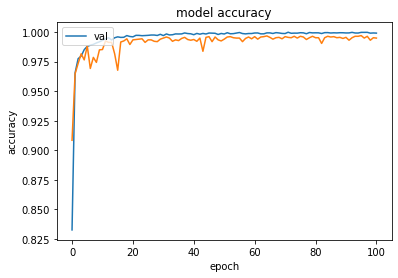

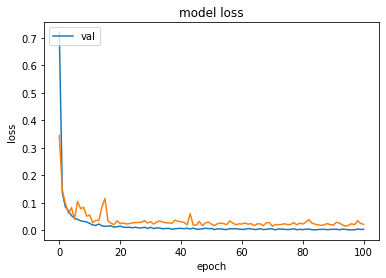

In [ ]:
if gpu:
    model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
    history = model.fit(X_train,train_label,batch_size=32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30)],validation_split=0.1)
if tpu:
    with strategy.scope():
        model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
        history = model.fit(X_train,train_label,batch_size=8*32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30)],validation_split=0.1)

plot_performance(X_train, train_label, history)

In [ ]:
get_test_performance(model, X_test, test_label)

117/117 [==============================] - 3s 25ms/step - loss: 0.6366 - accuracy: 0.9481 - auc: 0.9821 - recall: 0.9468
Test loss:0.6366384029388428
Test accuracy:0.948128342628479
Test Recall: 0.9467914700508118
Test AUC: 0.982114315032959


# Train Full Manually Dataset 1

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 6, 128)]     0           []                               
                                                                                                  
 permute_2 (Permute)            (None, 128, 6)       0           ['input_9[0][0]']                
                                                                                                  
 conv1d_6 (Conv1D)              (None, 128, 512)     28160       ['permute_2[0][0]']              
                                                                                                  
 batch_normalization_6 (BatchNo  (None, 128, 512)    2048        ['conv1d_6[0][0]']               
 rmalization)                                                                               

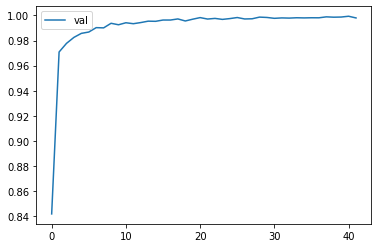

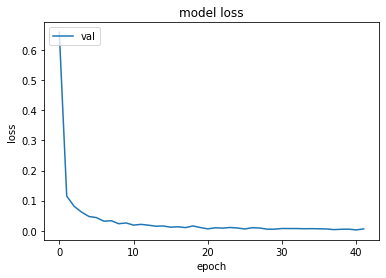

In [ ]:
#change 
epochs = 42
if gpu:
    model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
    history = model.fit(X_train,train_label,batch_size=32,epochs=epochs,verbose=1)
if tpu:
    with strategy.scope():
        model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
        history = model.fit(X_train,train_label,batch_size=8*32,epochs=epochs,verbose=1)

plot_performance(X_train, train_label, history)

In [ ]:
get_test_performance(model, X_test, test_label)

117/117 [==============================] - 8s 29ms/step - loss: 0.5294 - accuracy: 0.9401 - auc: 0.9810 - recall: 0.9380
Test loss:0.529437243938446
Test accuracy:0.9401069283485413
Test Recall: 0.9379678964614868
Test AUC: 0.9810404181480408


# Train 90%  Dataset 2

In [ ]:
np.random.seed(42)
X_train = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #2/train/Inertial Signals')
X_test = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #2/test/Inertial Signals')
train_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #2/train/y_train.txt')
test_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #2/test/y_test.txt')
shape = ((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
num_classes = 20

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 6, 128)]     0           []                               
                                                                                                  
 permute_3 (Permute)            (None, 128, 6)       0           ['input_10[0][0]']               
                                                                                                  
 conv1d_9 (Conv1D)              (None, 128, 512)     28160       ['permute_3[0][0]']              
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 128, 512)    2048        ['conv1d_9[0][0]']               
 rmalization)                                                                               

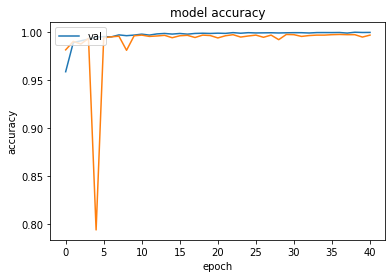

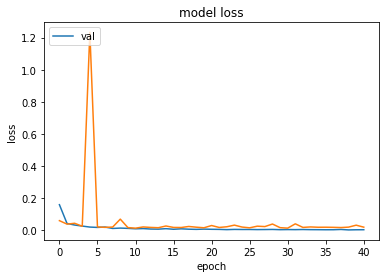

In [ ]:
if gpu:
    model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
    history = model.fit(X_train,train_label,batch_size=32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30)],validation_split=0.1)
if tpu:
    with strategy.scope():
        model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
        history = model.fit(X_train,train_label,batch_size=8*32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30)],validation_split=0.1)

plot_performance(X_train, train_label, history)

In [ ]:
get_test_performance(model, X_test, test_label)

155/155 [==============================] - 5s 31ms/step - loss: 0.2746 - accuracy: 0.9731 - auc: 0.9885 - recall: 0.9731
Test loss:0.274641752243042
Test accuracy:0.9730551242828369
Test Recall: 0.9730551242828369
Test AUC: 0.9885132908821106


# Train Full Manually Dataset 2

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 6, 128)]     0           []                               
                                                                                                  
 permute_4 (Permute)            (None, 128, 6)       0           ['input_11[0][0]']               
                                                                                                  
 conv1d_12 (Conv1D)             (None, 128, 512)     28160       ['permute_4[0][0]']              
                                                                                                  
 batch_normalization_12 (BatchN  (None, 128, 512)    2048        ['conv1d_12[0][0]']              
 ormalization)                                                                              

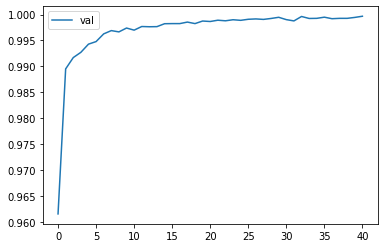

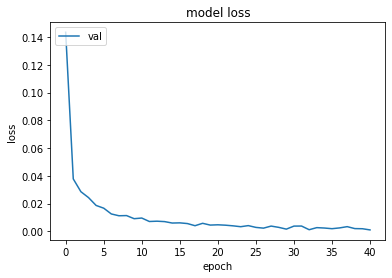

In [ ]:
#change
epochs = 41
if gpu:
    model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
    history = model.fit(X_train,train_label,batch_size=32,epochs=epochs,verbose=1)
if tpu:
    with strategy.scope():
        model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
        history = model.fit(X_train,train_label,batch_size=8*32,epochs=epochs,verbose=1)

plot_performance(X_train, train_label, history)

In [ ]:
get_test_performance(model, X_test, test_label)

155/155 [==============================] - 7s 25ms/step - loss: 0.1690 - accuracy: 0.9718 - auc: 0.9909 - recall: 0.9710
Test loss:0.16903646290302277
Test accuracy:0.9718395471572876
Test Recall: 0.9710291624069214
Test AUC: 0.990882933139801


# Train 90%  Dataset OU-ISIR

In [ ]:
num_classes = 745
np.random.seed(42)
X_train = load_X('/content/drive/Shareddrives/MMH/TIFS20/OU-ISIR_sensors_dataset/identification/data/train/data')
X_test = load_X('/content/drive/Shareddrives/MMH/TIFS20/OU-ISIR_sensors_dataset/identification/data/test/data')
train_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/OU-ISIR_sensors_dataset/identification/data/train/train_y.txt')
test_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/OU-ISIR_sensors_dataset/identification/data/test/test_y.txt')
print(f'{X_train.shape} {X_test.shape}')
model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])

(13212, 6, 128, 1) (1409, 6, 128, 1)
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 6, 128)]     0           []                               
                                                                                                  
 permute_1 (Permute)            (None, 128, 6)       0           ['input_2[0][0]']                
                                                                                                  
 conv1d_3 (Conv1D)              (None, 128, 512)     28160       ['permute_1[0][0]']              
                                                                                                  
 batch_normalization_3 (BatchNo  (None, 128, 512)    2048        ['conv1d_3[0][0]']               
 rmalization)                                          

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 6, 128)]     0           []                               
                                                                                                  
 permute_2 (Permute)            (None, 128, 6)       0           ['input_3[0][0]']                
                                                                                                  
 conv1d_6 (Conv1D)              (None, 128, 512)     28160       ['permute_2[0][0]']              
                                                                                                  
 batch_normalization_6 (BatchNo  (None, 128, 512)    2048        ['conv1d_6[0][0]']               
 rmalization)                                                                               

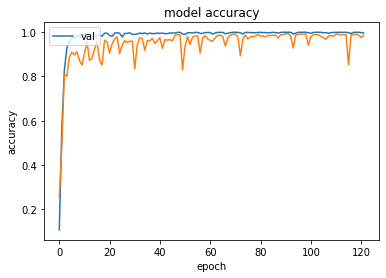

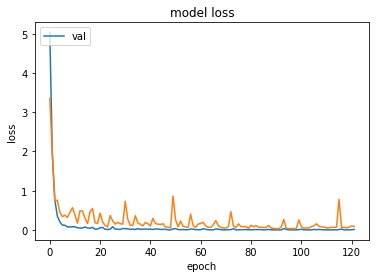

In [ ]:
if gpu:
    model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
    history = model.fit(X_train,train_label,batch_size=32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30)],validation_split=0.1)
if tpu:
    with strategy.scope():
        model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
        history = model.fit(X_train,train_label,batch_size=8*32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30)],validation_split=0.1)

plot_performance(X_train, train_label, history)

In [ ]:
get_test_performance(model, X_test, test_label)

45/45 [==============================] - 1s 24ms/step - loss: 0.1873 - accuracy: 0.9603 - auc: 0.9950 - recall: 0.9588
Test loss:0.187301367521286
Test accuracy:0.96025550365448
Test Recall: 0.9588360786437988
Test AUC: 0.9950218200683594


# Train Full Manually Dataset OU-ISIR

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 6, 128)]     0           []                               
                                                                                                  
 permute_3 (Permute)            (None, 128, 6)       0           ['input_4[0][0]']                
                                                                                                  
 conv1d_9 (Conv1D)              (None, 128, 512)     28160       ['permute_3[0][0]']              
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 128, 512)    2048        ['conv1d_9[0][0]']               
 rmalization)                                                                               

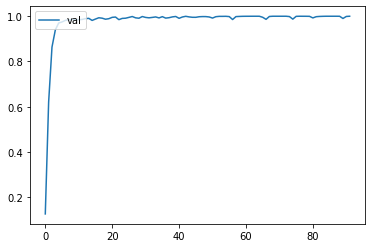

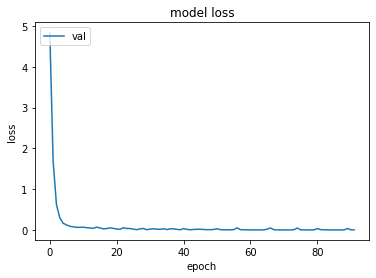

In [ ]:
# change
epochs = 92
if gpu:
    model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
    history = model.fit(X_train,train_label,batch_size=32,epochs=epochs,verbose=1)
if tpu:
    with strategy.scope():
        model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
        history = model.fit(X_train,train_label,batch_size=8*32,epochs=epochs,verbose=1)

plot_performance(X_train, train_label, history)

In [ ]:
get_test_performance(model, X_test, test_label)

45/45 [==============================] - 5s 27ms/step - loss: 0.1113 - accuracy: 0.9815 - auc: 0.9957 - recall: 0.9808
Test loss:0.11127341538667679
Test accuracy:0.9815471768379211
Test Recall: 0.9808374643325806
Test AUC: 0.9957383871078491


# Train Dataset 1 test=val

In [ ]:
np.random.seed(42)
num_classes = 118
X_train = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/train/Inertial Signals')
X_test = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/test/Inertial Signals')
train_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/train/y_train.txt')
test_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/test/y_test.txt')
shape = ((X_train.shape[1], X_train.shape[2]), train_label.shape[1])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 6, 128)]     0           []                               
                                                                                                  
 permute (Permute)              (None, 128, 6)       0           ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 128, 512)     28160       ['permute[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 512)    2048        ['conv1d[0][0]']                 
 alization)                                                                                   

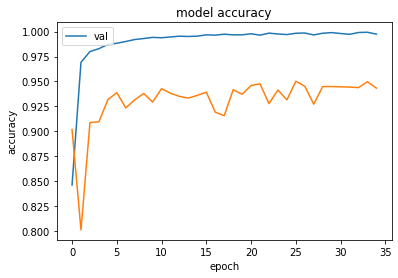

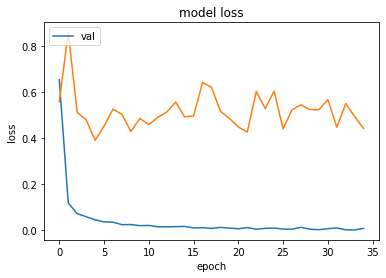

In [ ]:
if gpu:
    model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
    history = model.fit(X_train,train_label,batch_size=32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30)],validation_data=(X_test,test_label))
if tpu:
    with strategy.scope():
        model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
        history = model.fit(X_train,train_label,batch_size=8*32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30)],validation_data=(X_test,test_label))

plot_performance(X_train, train_label, history)

In [ ]:
get_test_performance(model, X_test, test_label)

117/117 [==============================] - 3s 26ms/step - loss: 0.4416 - accuracy: 0.9433 - auc: 0.9833 - recall: 0.9430
Test loss:0.44164615869522095
Test accuracy:0.9433155059814453
Test Recall: 0.9430481195449829
Test AUC: 0.9833304286003113


# Train dataset 2 test = val

In [13]:
np.random.seed(42)
X_train = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #2/train/Inertial Signals')
X_test = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #2/test/Inertial Signals')
train_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #2/train/y_train.txt')
test_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #2/test/y_test.txt')
shape = ((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
num_classes = 20

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 6, 128)]     0           []                               
                                                                                                  
 permute (Permute)              (None, 128, 6)       0           ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 128, 512)     28160       ['permute[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 512)    2048        ['conv1d[0][0]']                 
 alization)                                                                                   

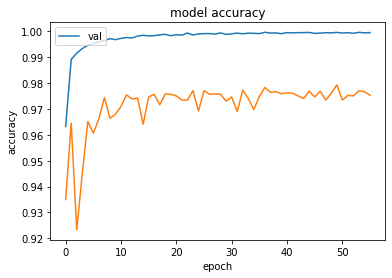

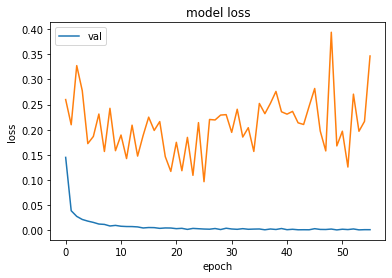

In [14]:
if gpu:
    model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
    history = model.fit(X_train,train_label,batch_size=32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30)],validation_data=(X_test,test_label))
if tpu:
    with strategy.scope():
        model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
        history = model.fit(X_train,train_label,batch_size=8*32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30)],validation_data=(X_test,test_label))

plot_performance(X_train, train_label, history)

In [15]:
get_test_performance(model, X_test, test_label)

155/155 [==============================] - 4s 24ms/step - loss: 0.3466 - accuracy: 0.9753 - auc: 0.9895 - recall: 0.9751
Test loss:0.34660133719444275
Test accuracy:0.9752836227416992
Test Recall: 0.9750810265541077
Test AUC: 0.9895175695419312


#Train Test = val Dataset OU-ISIR

In [16]:
num_classes = 745
np.random.seed(42)
X_train = load_X('/content/drive/Shareddrives/MMH/TIFS20/OU-ISIR_sensors_dataset/identification/data/train/data')
X_test = load_X('/content/drive/Shareddrives/MMH/TIFS20/OU-ISIR_sensors_dataset/identification/data/test/data')
train_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/OU-ISIR_sensors_dataset/identification/data/train/train_y.txt')
test_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/OU-ISIR_sensors_dataset/identification/data/test/test_y.txt')
print(f'{X_train.shape} {X_test.shape}')
model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])

(13212, 6, 128, 1) (1409, 6, 128, 1)
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 6, 128)]     0           []                               
                                                                                                  
 permute_1 (Permute)            (None, 128, 6)       0           ['input_2[0][0]']                
                                                                                                  
 conv1d_3 (Conv1D)              (None, 128, 512)     28160       ['permute_1[0][0]']              
                                                                                                  
 batch_normalization_3 (BatchNo  (None, 128, 512)    2048        ['conv1d_3[0][0]']               
 rmalization)                                          

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 6, 128)]     0           []                               
                                                                                                  
 permute_2 (Permute)            (None, 128, 6)       0           ['input_3[0][0]']                
                                                                                                  
 conv1d_6 (Conv1D)              (None, 128, 512)     28160       ['permute_2[0][0]']              
                                                                                                  
 batch_normalization_6 (BatchNo  (None, 128, 512)    2048        ['conv1d_6[0][0]']               
 rmalization)                                                                               

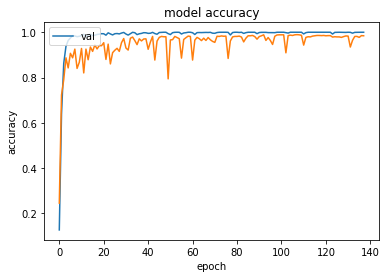

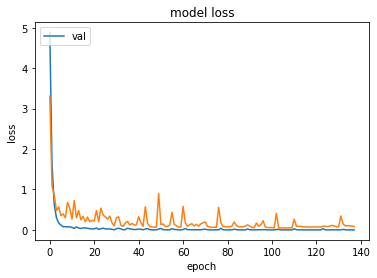

In [17]:
if gpu:
    model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
    history = model.fit(X_train,train_label,batch_size=32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30)],validation_data=(X_test,test_label))
if tpu:
    with strategy.scope():
        model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
        history = model.fit(X_train,train_label,batch_size=8*32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30)],validation_data=(X_test,test_label))

plot_performance(X_train, train_label, history)

In [18]:
get_test_performance(model, X_test, test_label)

45/45 [==============================] - 1s 24ms/step - loss: 0.0843 - accuracy: 0.9844 - auc: 0.9968 - recall: 0.9837
Test loss:0.08425227552652359
Test accuracy:0.9843860864639282
Test Recall: 0.9836763739585876
Test AUC: 0.9968050122261047


# Tune Test - > val 



In [19]:
np.random.seed(42)
num_classes = 118
X_train = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/train/Inertial Signals')
X_test = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/test/Inertial Signals')
train_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/train/y_train.txt')
test_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/test/y_test.txt')
shape = ((X_train.shape[1], X_train.shape[2]), train_label.shape[1])

In [ ]:
if gpu:
    tuner = kt.tuners.BayesianOptimization(post_se,
        objective='val_accuracy',
        max_trials=30,
        seed=42,
        project_name='Model_gpu')
    # Will stop training if the "val_loss" hasn't improved in 30 epochs.
    tuner.search(X_train, train_label, epochs=200, validation_data=(X_test,test_label), shuffle=True, callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30)])

if tpu:
    with strategy.scope():
        tuner = kt.tuners.BayesianOptimization(post_se,
            objective='val_accuracy',
            max_trials=30,
            seed=42,
            project_name='Model_tpu_test')
        # Will stop training if the "val_loss" hasn't improved in 30 epochs.
        tuner.search(X_train, train_label, epochs=200, validation_data=(X_test,test_label), shuffle=True, callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30)])

Trial 4 Complete [00h 28m 12s]
val_accuracy: 0.9433155059814453

Best val_accuracy So Far: 0.9502673745155334
Total elapsed time: 01h 54m 56s

Search: Running Trial #5

Hyperparameter    |Value             |Best Value So Far 
Bi-LSTM_1         |8                 |8                 
Dropout           |0.8               |0.8               
conv_1_filter     |512               |32                
conv_1_filter_size|9                 |9                 
conv_2_filter     |512               |256               
conv_2_filter_size|3                 |3                 
conv_3_filter     |512               |512               
conv_3_filter_size|9                 |3                 

Epoch 1/200
1035/1035 [==============================] - 90s 77ms/step - loss: 0.6166 - accuracy: 0.8550 - val_loss: 0.6020 - val_accuracy: 0.8904
Epoch 2/200
1035/1035 [==============================] - 75s 73ms/step - loss: 0.1171 - accuracy: 0.9696 - val_loss: 0.5149 - val_accuracy: 0.9144
Epoch 3/200
1035/1035 [

# MODEL DEFINITION for Second Tuning

In [ ]:
def MLSTM_FCN_2(shape, num_classes):
    x = Input(shape=(6, 128))
    ip = x
    x = Masking()(ip)
    x = Bidirectional(LSTM(units=8))(x)
    x = Dropout(0.8)(x)
    y = Permute((2, 1))(ip)
    y = Conv1D(32, 9, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = squeeze_excite_block(y)
    y = Conv1D(256, 3, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = squeeze_excite_block(y)
    y = Conv1D(512, 3, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = GlobalAveragePooling1D()(y)
    x = concatenate([x,y])
    
    out = Dense(num_classes, activation='softmax')(x)
    model = Model(ip, out)
    model.compile(optimizer="adam", loss="categorical_crossentropy",metrics=['accuracy','AUC','Recall'])
    model.summary()

    return model

# Train Dataset 1 test=val

In [ ]:
if gpu:
    model = MLSTM_FCN_2((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
    history = model.fit(X_train,train_label,batch_size=32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30)],validation_data=(X_test,test_label))
if tpu:
    with strategy.scope():
        model = MLSTM_FCN_2((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
        history = model.fit(X_train,train_label,batch_size=8*32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30)],validation_data=(X_test,test_label))

plot_performance(X_train, train_label, history)

In [ ]:
get_test_performance(model, X_test, test_label)

# Train dataset 2 test = val

In [ ]:
np.random.seed(42)
X_train = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #2/train/Inertial Signals')
X_test = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #2/test/Inertial Signals')
train_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #2/train/y_train.txt')
test_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #2/test/y_test.txt')
shape = ((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
num_classes = 20

In [ ]:
if gpu:
    model = MLSTM_FCN_2((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
    history = model.fit(X_train,train_label,batch_size=32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30)],validation_data=(X_test,test_label))
if tpu:
    with strategy.scope():
        model = MLSTM_FCN_2((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
        history = model.fit(X_train,train_label,batch_size=8*32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30)],validation_data=(X_test,test_label))

plot_performance(X_train, train_label, history)

In [ ]:
get_test_performance(model, X_test, test_label)

#Train Test = val Dataset OU-ISIR

In [ ]:
num_classes = 745
np.random.seed(42)
X_train = load_X('/content/drive/Shareddrives/MMH/TIFS20/OU-ISIR_sensors_dataset/identification/data/train/data')
X_test = load_X('/content/drive/Shareddrives/MMH/TIFS20/OU-ISIR_sensors_dataset/identification/data/test/data')
train_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/OU-ISIR_sensors_dataset/identification/data/train/train_y.txt')
test_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/OU-ISIR_sensors_dataset/identification/data/test/test_y.txt')
print(f'{X_train.shape} {X_test.shape}')
model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])

In [ ]:
if gpu:
    model = MLSTM_FCN_2((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
    history = model.fit(X_train,train_label,batch_size=32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30)],validation_data=(X_test,test_label))
if tpu:
    with strategy.scope():
        model = MLSTM_FCN_2((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
        history = model.fit(X_train,train_label,batch_size=8*32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30)],validation_data=(X_test,test_label))

plot_performance(X_train, train_label, history)

In [ ]:
get_test_performance(model, X_test, test_label)